Osnabrück University - A&C: Computational Cognition (Summer Term 2019)

# Exercise Sheet 07: EEG simulation & filtering in 2-D

## Introduction

This week's sheet should be solved and handed in at 14:00 at **Tuesday, June 18, 2019**. If you need help (and Google and other resources were not enough), feel free to contact your tutors. Please push your results to your Github group folder.

In this sheet we are going dig deeper into signal processing. Specifically, we will learn how the basic concepts in signal processing expand to 2-D space. You will need to have understandings of what fourier transform and inverse transform do and what kind of effect convolution has.

 Let's say your friend wants to send you a deep picture per messaging app. But he is too afraid that the server might get hacked. Therefore he decides to add some noise in his picture and just sends you the 2d shaped text file of the image. Now you have to denoise the image to see it. Surely you can use a simple filtering function to achieve this, but that sounds too boring for you. Instead, you want to convolve the filter and the image in a spatial domain.

In [1]:
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import fftpack
from scipy import signal

# set the default back- and foreground color for all the plots
plt.rcParams['axes.facecolor'] = 'lavender'


## Assignment 0: Peer review for sheet 07 [0 pts]

This week there will be no peer-review for obvious reasons.

## Assignment 1: Simulate 4-channel EEG signal [4 pts]

Before starting with the image, we will try to approximate an actual EEG signal as an extension from next week's sheet. Although our later EEG data will be composed of 64 channels, we will stick with 4 for simplicity. 

### a) Generate signal [3 pts]

Write a function that creates the signal for one channel, given a certain frequency-list (4 different frequencies) and the length of the signal. 
Within the function:
- First, define a sampling rate of 1000 Hz and a time-window of 1 second (i.e. 1000 ms)
- Define a list that assigns an amplitude to each element of frequencyList: For this, randomly draw with replacement from a range between 0 and 30 (hint: you need as many amplitude-samples as number of elements in frequencyList, checkout *np.random.choice*)
- Create each signal component with given frequency and amplitude. Add them all up.
- Add a small Gaussian noise to the signal.

In [2]:
def generateSignal(frequencyList,signalLen=1000):
    '''
    This function takes a list of frequencies and a time value in ms
    and returns a signal.
    '''

    # set the signal length / timeline
    t = np.linspace(0, 1, signalLen, False)
    
    # create a list of amplitudes
    ampList = np.random.choice(30, len(frequencyList), replace=True)
    
    # create the signal, by adding the frequencies in the 
    signal = sum([duo[1] * np.sin(2 * np.pi * t * duo[0]) for duo in list(zip(frequencyList, ampList))])
    
    # create Gussian noise
    noise = np.random.normal(0, 2, signalLen)
    signal_noisy = signal + noise # and add it to the signal

    return signal_noisy


### b) Plot [1 pt]
Once you wrote the function, use it to create 4 differnet signals (which each represent a channel). To make it more realistic, randomly sample frequencies of each signal from a common EEG frequency-band. These 4 common EEG frequency-bands are already given below.
 
Lastly, plot these 4 different signals.

In [3]:
# define frequency-bands typical for EEG data
delta = list(range(0,4))
theta = list(range(4,8))
alpha = list(range(8,14))
beta = list(range(13,31))
frexlist = [delta, theta, alpha, beta]


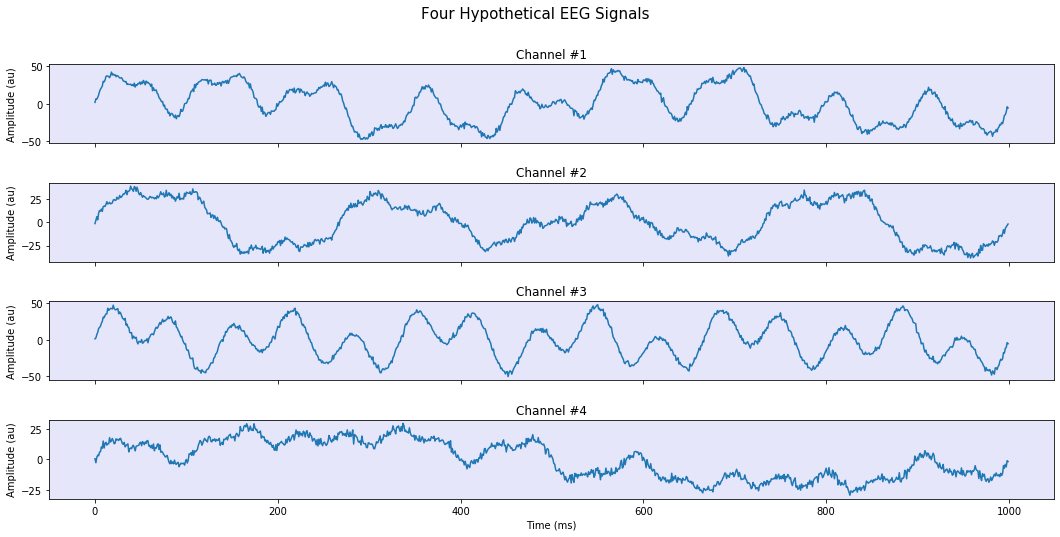

In [4]:
# create 4 signals for each channel, with random frequency combinations
# and plot them, the same time
# ---------------------------------------------------------------------

# define a function for picking random frequency from the four frequency-bands
def randomFrequency(frexlist=frexlist):
    '''
    This function takes the 'frexlist' and returns a list
    of four frequencies, each randomly picked from one of
    the four frequency bands available in the frexlist.
    '''
    # set an empty list for appending frequencies to
    freqList = []
    # iterate over the bands and pick one random frequency from each
    for i in range(4): freqList.append(np.random.choice(frexlist[i], replace=False))
    return freqList


# set the space and title for the four plots
figs, axes = plt.subplots(nrows=4, figsize=(18,8), sharex=True)
plt.suptitle('Four Hypothetical EEG Signals', fontsize=15)
plt.subplots_adjust(hspace=0.5)

# create an empty list for saving the signals
signaList = []

# create the four signals and add their plot to the plot-space
for i in range(4):
    signaList.append(generateSignal(randomFrequency(), signalLen=1000))
    axes[i].plot(signaList[i])
    axes[i].title.set_text('Channel #' + str(i+1))
    axes[i].set_ylabel('Amplitude (au)')
    
# set the x-axis label
axes[3].set_xlabel('Time (ms)');


### BONUS!
### a) Power-Spectogram
compute and plot the nice and colorful power-spectogram of our signals with *plt.specgram*

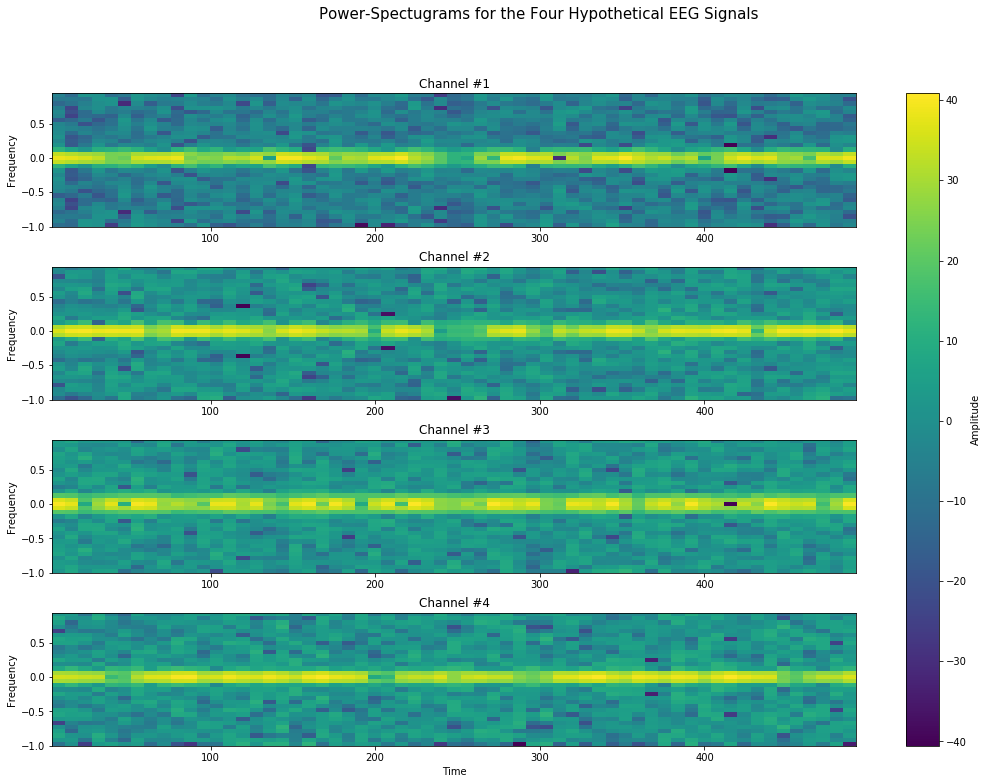

In [5]:
# set the space and title for the four plots
figs, axes = plt.subplots(nrows=4, figsize=(18,12))
plt.suptitle('Power-Spectugrams for the Four Hypothetical EEG Signals', fontsize=15)
plt.subplots_adjust(hspace=0.3)

# plot the spectugrams
for i in range(4):
    axes[i].specgram(signaList[i], NFFT=32, Fs=2, noverlap=16, sides='twosided')
    axes[i].title.set_text('Channel #' + str(i+1))
    axes[i].set_ylabel('Frequency')

# set the x-axis labels, and
axes[3].set_xlabel('Time')

# the colorbar
mappable = axes[1].images[0]
figs.colorbar(mappable=mappable, ax=axes.ravel().tolist()).set_label('Amplitude');


## Assignment 2: Load the data [1 pts]
Now let's start cracking the puzzle. Because your friend just sent you some text file, you need to load them into an image.
- First load the text file into a numpy array.
- Plot this numpy array. Use a gray colormap.

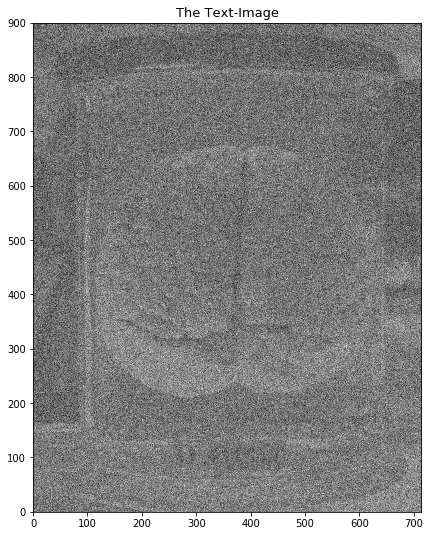

In [6]:
# load the text into a numpy array
image_text = np.loadtxt('important.txt')

# plot the numpy array
plt.figure(figsize=(7.14, 9))
plt.title('The Text-Image', fontsize=13)
plt.imshow(image_text, extent=(0,image_text.shape[1],0,image_text.shape[0]), cmap='gray');


## Asignment 3: Fourier transform [2 pts]
Do a fourier transform on the image.
- Don't panic. It's just the same concept, only in a 2-D space rather than in a 1-D space. 
- If you use ***numpy.fftpack.fft2***, you should shift the zero-frequency component to be at the center by ***numpy.fftpack.fftshift***.
- You should plot the power spectrum of the fourier transformed image at the end. 
- See https://www.gaussianwaves.com/2015/11/interpreting-fft-results-obtaining-magnitude-and-phase-information/ for differences between magnitiude, phase and power (amplitude).
- Use log scale in the plot. Check the parameter @norm of ***matplotlib.pyplot.imshow***.

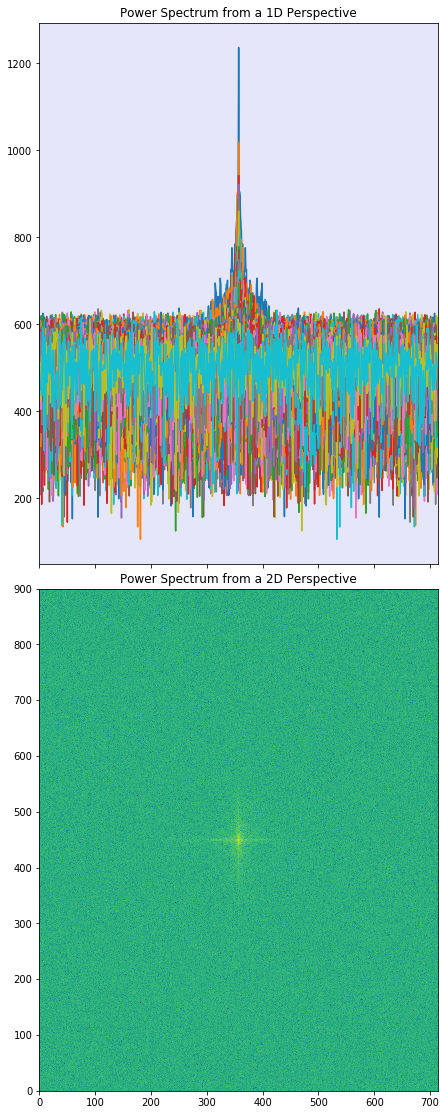

In [7]:
# calculate the 2D Fourier transform of the text-image
freqs = fftpack.fft2(image_text)

# shift the zero-frequency component to the center
img_freqs = fftpack.fftshift(freqs)

# compute the power spectrum
power_spectrum = 20*np.log10(np.abs(img_freqs))**2

# set the space for two plots
figs, axes = plt.subplots(nrows=2, sharex=True, figsize=(7.14,20))
plt.subplots_adjust(hspace=0.01)

# plot the power spectrum of the Fourier transform in 1D, and
axes[0].title.set_text('Power Spectrum from a 1D Perspective')
axes[0].set_xlim(0,714)
axes[0].plot(power_spectrum.T)
# 2D
axes[1].title.set_text('Power Spectrum from a 2D Perspective')
axes[1].imshow(power_spectrum, extent=(0,image_text.shape[1],0,image_text.shape[0]),
               norm=mpl.colors.LogNorm());


## Assignment 4: Create low pass filter [2 pts]
To filter the image, you need a filter. We are going to use a low pass filter (2-D Gaussian). 
- Your distribution should be rotationally symmetric for every angle.
- The filter should have 120 x 120 size, and the standard deviation should be 3.
- In our case it's easy to go from 1-D Gaussian distribution to 2-D Gaussian distribution, because there are no interaction between two dimensions (covariance matrix would be diagonal).
- Plot your filter.

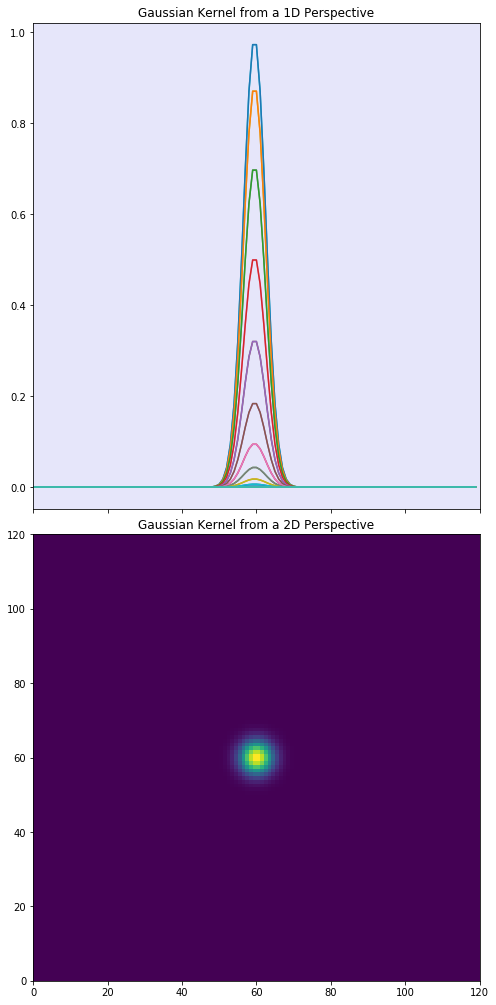

In [8]:
# create a 1D Gaussian vector
gaussian_1d = signal.gaussian(120, std=3)

# create a 2D Gaussian out of it using outer product
gaussian_2d = np.outer(gaussian_1d, gaussian_1d)

# set the space for two plots
figs, axes = plt.subplots(nrows=2, sharex=True, figsize=(8,18))
plt.subplots_adjust(hspace=0.01)

# plot the filter in 1D, and
axes[0].title.set_text('Gaussian Kernel from a 1D Perspective')
axes[0].plot(gaussian_2d)
# 2D
axes[1].title.set_text('Gaussian Kernel from a 2D Perspective')
axes[1].imshow(gaussian_2d, extent=(0,120,0,120));


## Assignment 5: Back to space [2 pts]
Right now the picture and the filters are both in frequency domain. Let's bring them back to the spatial domain. For this, you can use an inverse fourier transform function (I know, we computed fourier transform of the picture for nothing). 
- Compute the inverse fourier transform for both the image and the kernel.
- Compute power spectrum of these.

In [9]:
# compute the ifft for the image, and
image_inv_fft = np.real(np.fft.ifft2(img_freqs))
# the kernel
kernel_inv_fft = np.real(np.fft.ifft2(gaussian_2d))


# compute the power spectrum for the image, and
image_power_spectrum = np.abs(image_inv_fft)**2 #*20
# the kernel
# compute the power spectrum
kernel_power_spectrum = np.abs(kernel_inv_fft)**2 #*20 and log10


## Assignment 6: Convolution [2 pts]

To boost your intuition of convoultion in 2-d space, I recommend the following blog article.
http://www.songho.ca/dsp/convolution/convolution2d_example.html


We are almost there. Now we just have to convolve the image and the filter in spatial domain (use the computed power spectra of assignment 5 for this) and plot the picture. Do you recognise the object in the picture?

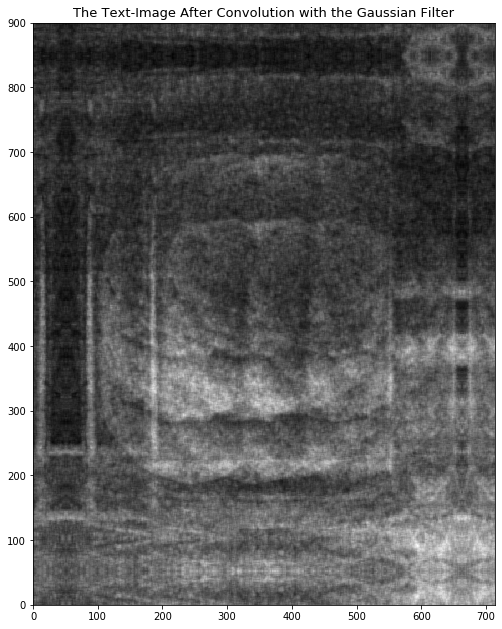

In [10]:
# calculate the convolution
conv = signal.convolve2d(image_power_spectrum, kernel_power_spectrum,
                         mode='full', boundary='symm')

# and plot the results
plt.figure(figsize=(13.8, 10.71))
plt.title('The Text-Image After Convolution with the Gaussian Filter', fontsize=13)
plt.imshow(conv, extent=(0,714,0,900), cmap='gray');


What do you see? 

**I was, first and before all theses vain efforts, able to see a brain in a jar, but now it is hardly recognizable!**
**I guess something is wrong with the kernel you defined, std=3 and the length 120?**

![Trump](https://user-images.githubusercontent.com/27868570/59549114-4096d980-8f59-11e9-8653-d9c8fd6b6a34.gif "Trump")

**Here we try a larger std for our Gaussian kernel and will check the result.**

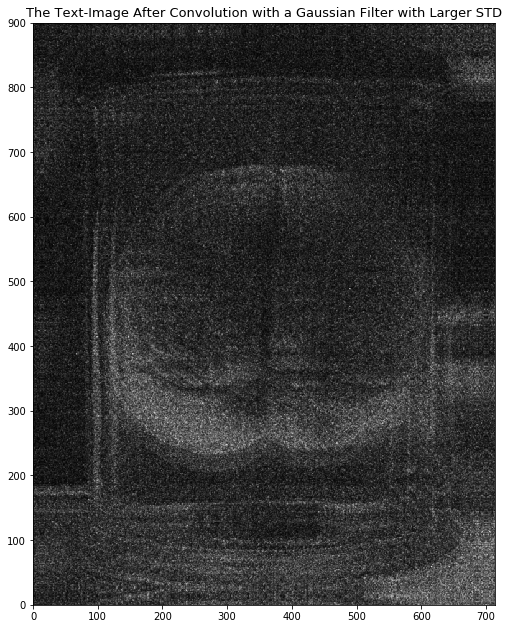

In [11]:
# create a 1D Gaussian vector
gaussian_1d_test = signal.gaussian(30, std=3)

# create a 2D Gaussian out of it using outer product
gaussian_2d_test = np.outer(gaussian_1d_test, gaussian_1d_test)

# compute the ifft for the kernel
kernel_inv_fft_test = np.real(np.fft.ifft2(gaussian_2d_test))

# compute the power spectrum for the kernel
kernel_power_spectrum_test = np.abs(kernel_inv_fft_test)**2

# calculate the convolution
conv = signal.convolve2d(image_power_spectrum, kernel_power_spectrum_test,
                         mode='full', boundary='symm')

# and plot the results
plt.figure(figsize=(13.8, 10.71))
plt.title('The Text-Image After Convolution with a Gaussian Filter with Larger STD', fontsize=13)
plt.imshow(conv, extent=(0,714,0,900), cmap='gray');

**Okay, maybe I was wrong to think the kernel design is the problem, cause neither increasing the std nor decreasing the kernel length did not change the results that much better. Still working...**